In [1]:
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams['figure.dpi'] = 200

# Generating statistics relevant for RRS genotyping design

The goal is to identify relevant statistics that would allow us to assess if a species/genome is suitable for a designed reduced representation. I want to determine if the restriction enzyme cuts fragments that are suitable for adaptor PCR-based filtration and that the skew of the cuts are not beyond the expected average of a 4-6 bp cutter. 

In [17]:
# Helper class
from collections import defaultdict

class reSites:
    
    def __init__(self, fai, refile):
        # initiation attributes
        self.chrlens = dict()
        self.reDict = defaultdict(dict)
        self.reEnzymes = set()
        self._loadChrLens(fai)
        self._loadREData(refile)
        
        
        # calculation attributes
        self.reFragLens = defaultdict(list)
        self.reFragCoords = defaultdict(list)
        
    def _loadChrLens(self, fai):
        with open(fai, 'r') as input:
            for l in input:
                s = l.rstrip().split()
                self.chrlens[s[0]] = int(s[1])
    
    def _loadREData(self, refile):
        with open(refile, 'r') as input:
            for l in input:
                s = l.rstrip().split("\t")
                s[2] = s[2].replace("[", "").replace("]", "").replace(',', "")
                v = s[2].split()
                self.reEnzymes.add(s[1])
                # Convert all values to int for easier comparisons later
                self.reDict[s[0]][s[1]] = list(map(lambda x: int(x), v))
    
    def calcFragments(self):
        for r in self.reEnzymes:            
            for c, l in self.chrlens.items():
                last = 0
                for bp in self.reDict[c][r]:
                    fglen = bp - last
                    self.reFragLens[r].append(fglen)
                    self.reFragCoords[r].append(f'{c}\t{last + 1}\t{bp}')
                    last = bp
                fglen = l - last
                self.reFragLens[r].append(fglen)
                self.reFragCoords[r].append(f'{c}\t{last + 1}\t{l}')
                
    def fragLensToDF(self):
        hdict = defaultdict(list)
        for re, ls in self.reFragLens.items():
            for l in ls:
                hdict["Enzyme"].append(re)
                hdict["Length"].append(l)
        return pd.DataFrame(hdict, columns = ["Enzyme", "Length"])

---
## Loading data

OK, I have a decent number of helper functions written, let's load the files and then start generating some general plots and statistics.

In [18]:
from pathlib import Path
baseURL = r"C:\Users\Derek.Bickhart\OneDrive - Hendrix Genetics\Documents\work_data\insects\blackSoldierFly\reduced_representation\\"

worker = reSites(Path(baseURL + 'GCF_905115235.1_iHerIll2.2.curated.20191125_genomic.fna.fai'), Path(baseURL + 'restriction_sites.tab'))   

print("Loaded")

Loaded


---
## Diagnostic plots of fragment lengths

OK, let's see the distributions of fragment lengths first. We will need to do a log transform to actually visualize the data, but then we will bound the viable fragments (between 300 and 500 bp) with red bars for better visualization.

In [21]:
worker.calcFragments()

ldf = worker.fragLensToDF()

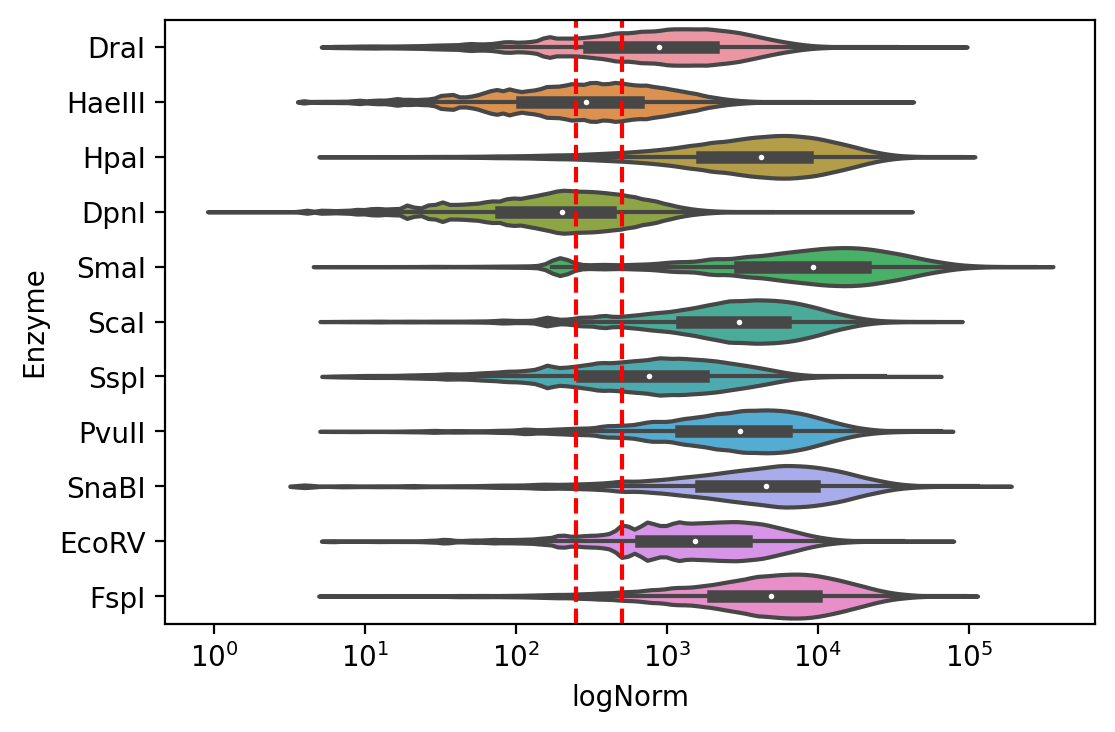

In [25]:
from matplotlib import ticker as mticker
ldf['logNorm'] = np.log10(ldf['Length'])

ax = plt.gca()
sns.violinplot(data=ldf, x="logNorm", y="Enzyme")
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
plt.axvline(x = 2.4, color = 'r', ls = '--')
plt.axvline(x = 2.7, color = 'r', ls = '--')
plt.show()

---
Now let's see how much of the actual genome assembly is covered by fragments of that length. I will generate a cummulative length plot here. 

[(0.0, 1004948288.0)]

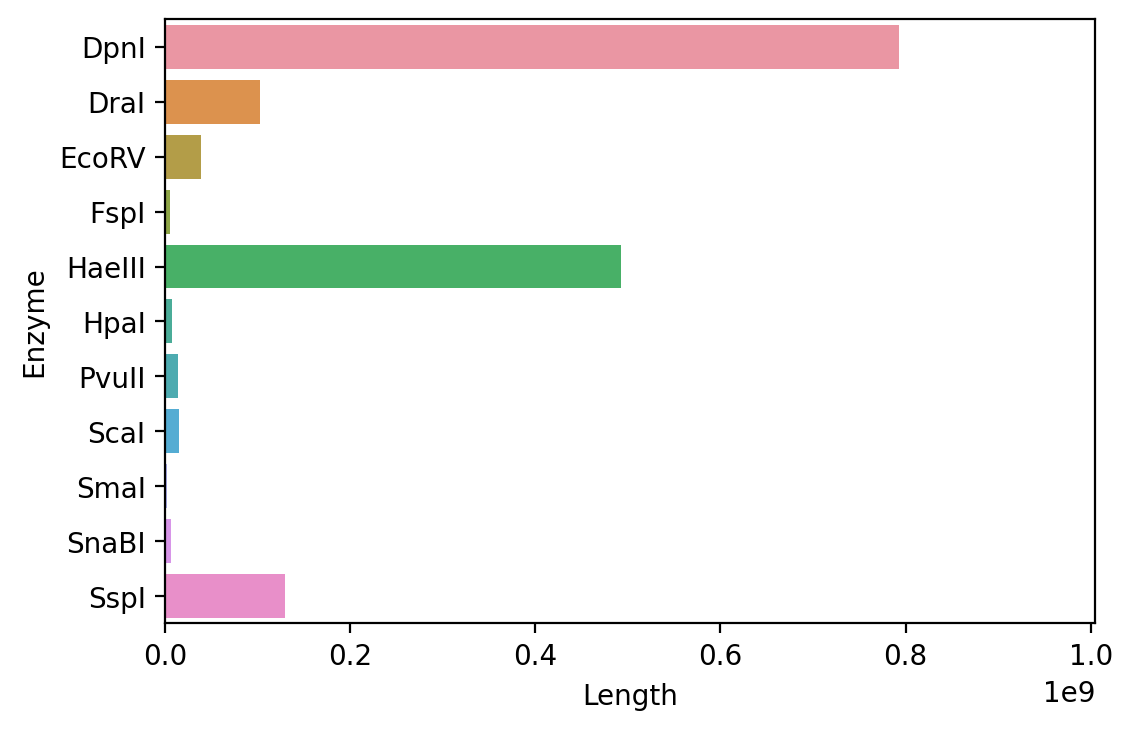

In [39]:
fdf = ldf[ldf['logNorm'].between(2.4, 2.7, inclusive= "both")]
sums = fdf.groupby(['Enzyme'], as_index=False).agg({"Length":"sum", "logNorm": "sum"})
#print(sums)

genomeLen = 0
for k, i in worker.chrlens.items():
    genomeLen += i

ax = plt.gca()
sns.barplot(data=sums, x="Length", y="Enzyme")
ax.set(xlim=(0, genomeLen))

---

So far, both SspI and DraI appear to be in the "Goldilocks" zone, where they cover a lesser, but more reasonable percentage of the genome sequence, whereas DpnI and HaeIII have a distribution of fragments that would cover a larger percentage of the genome within this size range. 

---
## Printing out BED coordinates

OK, for my final trick, I am going to print out the coordinates of the cut sites for the four enzymes I mentioned above. Then we should intersect them with the regions indicated by the Fst screen that Katrijn and Elena conducted. 

In [42]:
for r, coords in worker.reFragCoords.items():
    with open(Path(baseURL + f'{r}_blackSFly_cuts.bed'), 'w') as output:
        for c in coords:
            output.write(c + '\n')
    print(f'Wrote out file: {r}_blackSFly_cuts.bed')

Wrote out file: DraI_blackSFly_cuts.bed
Wrote out file: HaeIII_blackSFly_cuts.bed
Wrote out file: HpaI_blackSFly_cuts.bed
Wrote out file: DpnI_blackSFly_cuts.bed
Wrote out file: SmaI_blackSFly_cuts.bed
Wrote out file: ScaI_blackSFly_cuts.bed
Wrote out file: SspI_blackSFly_cuts.bed
Wrote out file: PvuII_blackSFly_cuts.bed
Wrote out file: SnaBI_blackSFly_cuts.bed
Wrote out file: EcoRV_blackSFly_cuts.bed
Wrote out file: FspI_blackSFly_cuts.bed
